# Generating Expected Threat (xT) 

## Introduction

Welcome to this Jupyter Notebook, where we delve into the exciting world of Expected Threat (xT) metrics in the context of football (soccer) analytics. The concept of Expected Threat, popularized by Karun Singh and others, provides a powerful framework for quantifying the potential threat posed by a team or player in different regions of the field.

Expected Threat is a statistical metric that assigns a numerical value to each location on the pitch, reflecting the likelihood of a goal being scored in the same possession based on historical data. This metric is helpfull for gaining insights into team strategies, player performance, and overall match dynamics.

The notebook is a showcase of how the xT in the `databallpy` package is calculated. However, it is closely based on the work and blog of Karun Singh (see the article [here](https://karun.in/blog/expected-threat.html))

## What to Expect

1. **Data Loading:** We will start by loading football event data into our Jupyter environment. The dataset will serve as the foundation for our xT calculations. Note that the data is not publicaly available.

2. **xT Calculation:** We will dive into the mathematical foundations of Expected Threat, discussing how to compute xT values for various events on the field. You'll gain insights into the factors influencing threat levels and how to model them effectively.

3. **Visualization:** Effective visualization is key to understanding and communicating xT metrics. We'll explore different plotting techniques to represent xT values spatially on the football pitch.

In [13]:
import pandas as pd
import math
from databallpy.visualize import plot_soccer_pitch
from databallpy.features.angle import get_smallest_angle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import joblib
import matplotlib.patches as mpatches

## Read in the Dataset

The used data to create this model is non-public data. It contains event data of over 600 matches. For every on-ball event (pass, shot, or dribble) we indicate whether it was successful, what the start location was of the event, and for passes and dribbles, what the end location of the event was if the event was successful. Note that all events are normalised so that the goal is to score on the right side of the pitch.

In [14]:
df = pd.read_pickle("data/positions_goals_dataset2.pkl") # note this is a local dataset

# exclude own goals and goals scored from own half, probably an event data error
df = df[df["event"]!="own_goal"]
df = df[~((df["event"]=="shot") & (df["successful"]==1) & (df["start_x"] < 0))]
print(df["set_piece"].value_counts())
df = df[df["set_piece"]=="no_set_piece"]
df.shape

set_piece
no_set_piece    572116
throw_in         25824
free_kick        13770
goal_kick         9770
corner_kick       6127
kick_off          2965
penalty            123
Name: count, dtype: int64


(572116, 13)

## Define Constants

Now we will define the constants for the grid over the pitch, and the size of the pitch

In [15]:
N_X_BINS = 32
N_Y_BINS = 24
X_RANGE = (-53, 53)
Y_RANGE = (-34, 34)
pitch_length = 106
pitch_width = 68
cell_length = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
cell_width = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

## Visualisations of Dataset

Now it's important to check what are data actually looks like. In the next part we will look at the success rate of all actions, shots, and where on the pitch these actions happen.

In [16]:
params = {"bins": (N_X_BINS, N_Y_BINS), "range": [X_RANGE, Y_RANGE]}

hist_events, x_edges, y_edges = np.histogram2d(df['start_x'], df['start_y'], **params)
hist_shots, _, _ = np.histogram2d(df.loc[df["event"]=="shot", 'start_x'], df.loc[df["event"]=="shot", 'start_y'], **params)
hist_goals, _, _ = np.histogram2d(
    df.loc[((df["event"]=="shot") & (df["successful"]==1)), 'start_x'], 
    df.loc[((df["event"]=="shot") & (df["successful"]==1)), 'start_y'], 
    **params
) 
hist_ball_moves, _, _ = np.histogram2d(df.loc[df["event"]!="shot", 'start_x'], df.loc[df["event"]!="shot", 'start_y'], **params)
hist_ball_moves_succ, _, _ = np.histogram2d(
    df.loc[((df["event"]!="shot") & (df["successful"]==1)), 'start_x'], 
    df.loc[((df["event"]!="shot") & (df["successful"]==1)), 'start_y'], 
    **params
)
ratio_shots = np.divide(hist_shots, hist_events, where=hist_events!=0)
ratio_goals = np.divide(hist_goals, hist_shots, where=hist_shots!=0)
ratio_ball_moves = np.divide(hist_ball_moves, hist_events, where=hist_events!=0)
ratio_ball_moves_succ = np.divide(hist_ball_moves_succ, hist_ball_moves, where=hist_ball_moves!=0)
ratio_failed_actions = 1 - (ratio_ball_moves * ratio_ball_moves_succ) - (ratio_shots * ratio_goals)

In [33]:
def plot_results(data, title=None, label=None, add_text=True, add_cbar=True, x_edges_func=x_edges, y_edges_func=y_edges, n_x_bins_func=N_X_BINS, n_y_bins_func=N_Y_BINS):
    fig, ax = plot_soccer_pitch(pitch_color="white")
    pcm = ax.pcolormesh(x_edges_func, y_edges_func, data.reshape(n_x_bins_func, n_y_bins_func).T * 100, cmap='coolwarm', alpha=0.9)
    if add_cbar:
        cbar = plt.colorbar(pcm, ax=ax, label=label)
    ax.set_title(title)
    
    if add_text:
        cell_length_func = 106 /n_x_bins_func 
        cell_width_func = 68 / n_y_bins_func
        for idx in range(len(data)):
            x1 = X_RANGE[0] + (idx // n_y_bins_func) * cell_length_func
            y1 = Y_RANGE[0] + (idx % n_y_bins_func) * cell_width_func
            ax.text(x=x1 +cell_length_func/2, y=y1+cell_width_func/2, s=f"{round(data[idx] *100)}", fontsize=7, alpha=0.8, color='black', ha='center', va='center')
    plt.show()

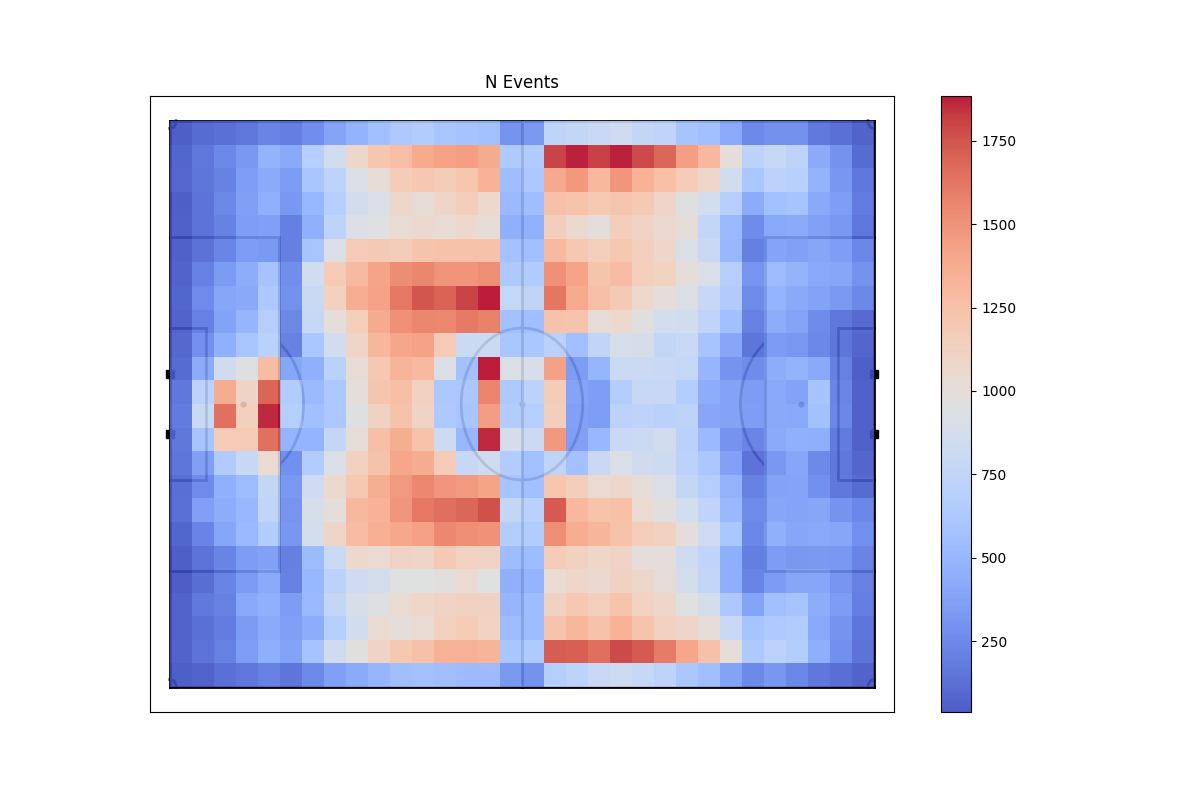

In [18]:
titles = ["N Events", "Percentage Shots of all Events", "Percentage Goals of all Shots", "Percentage Ball Moves of all Events", "Percentage Successful Moves of all Ball Moves"]
ratios = [hist_events, ratio_shots, ratio_goals, ratio_ball_moves, ratio_ball_moves_succ]

# Divide by 100 because it aims to make percentages of it, does not make sence it this case
plot_results(hist_events.ravel()/100., title=titles[0], add_text=False, )

This plot shows for every cell in the grid, the number of events that are happening there. Interestingly, you can see that around the middle line and the circle, less events occur. This has probably to do with a bias in the event data software to place an event in a specified part of the pitch. For now we can not do much about that. Note that we excluded set piece from this plot for now, but we can also make one with set pieces of course.

Let's have a look at how the different types of events, and their success rate, are divided over the pitch.

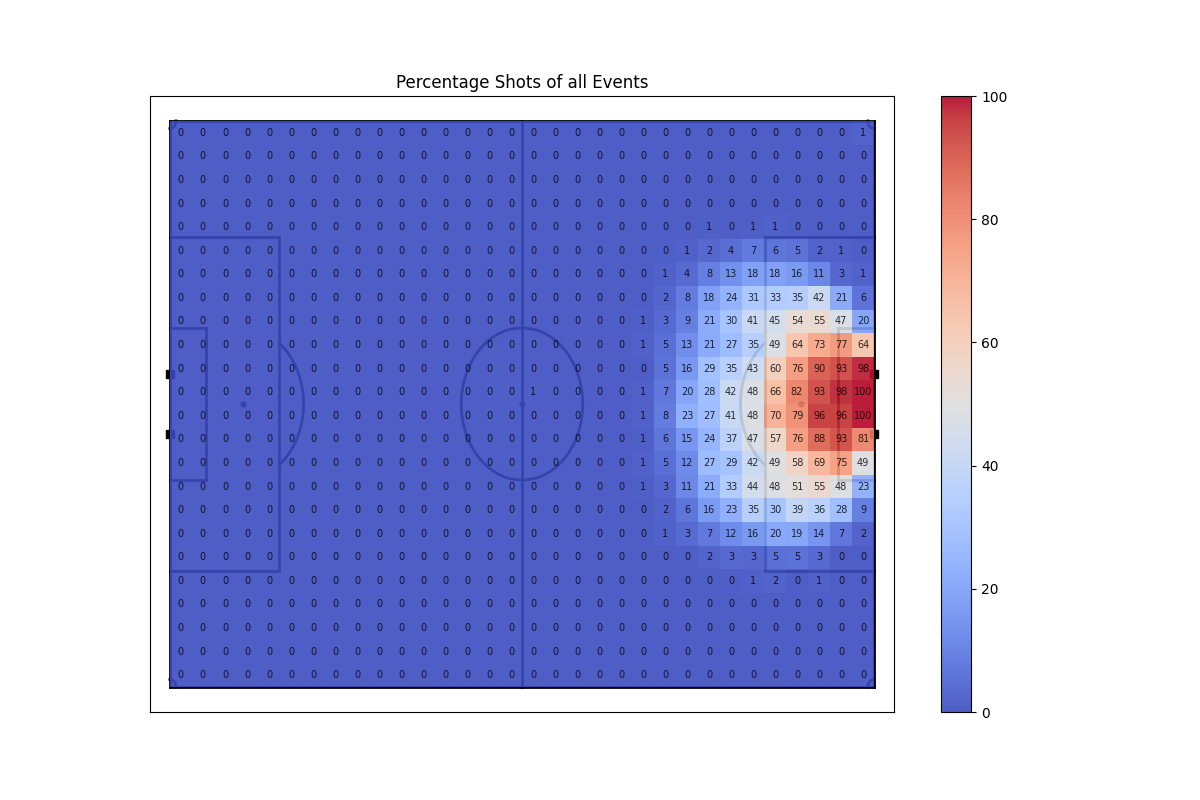

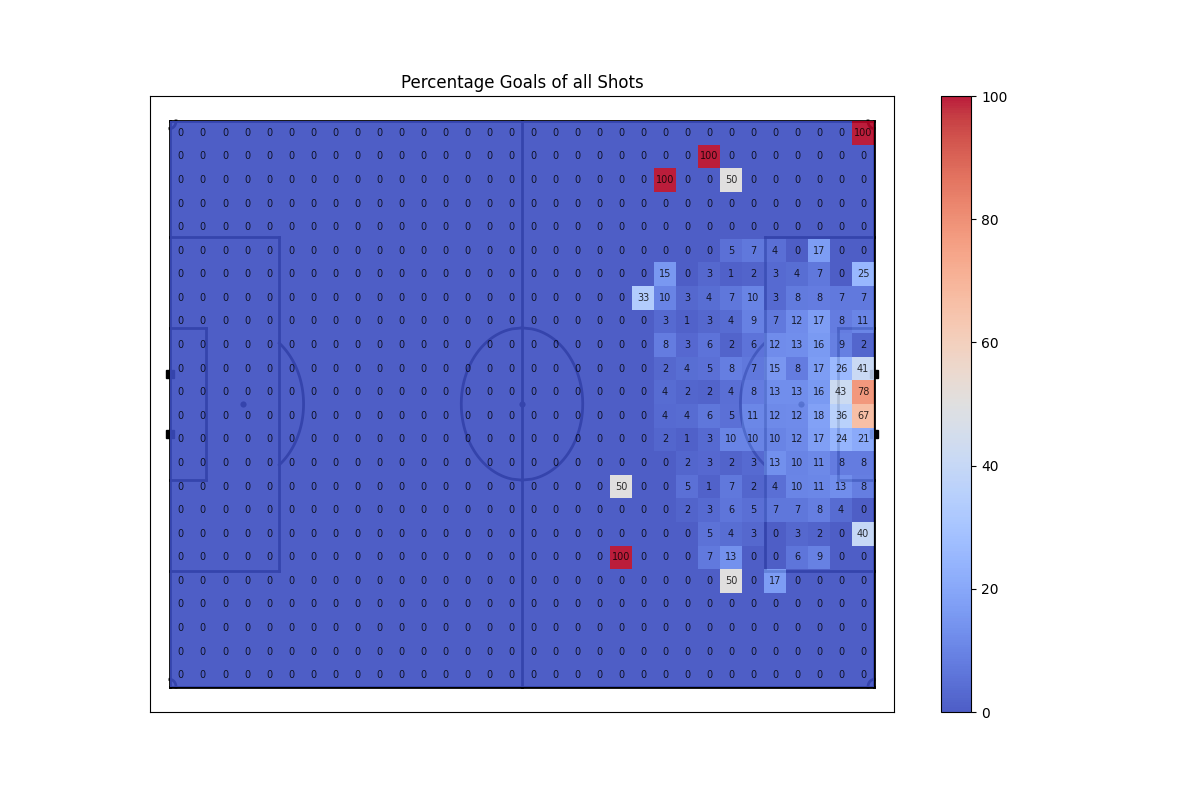

In [19]:
for title, data in zip(titles[1:3], ratios[1:3]):
    plot_results(data.ravel(), title=title, add_text=True)

As expected, shots are mainly taken from the around the box, with a bias towards the centre of the pitch. Some of the shots from far away went in, providing a 100% score for certain cells, but it is likely that this was a very specific case, not very representative for normal events.

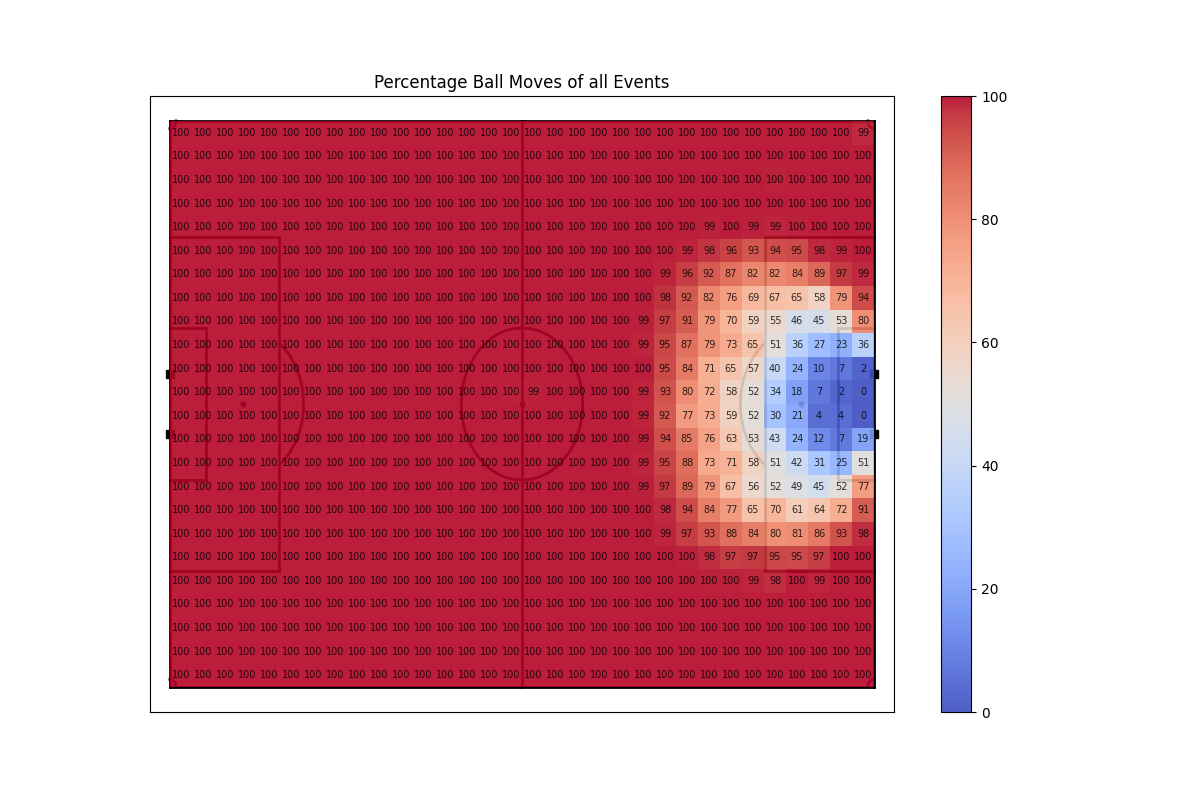

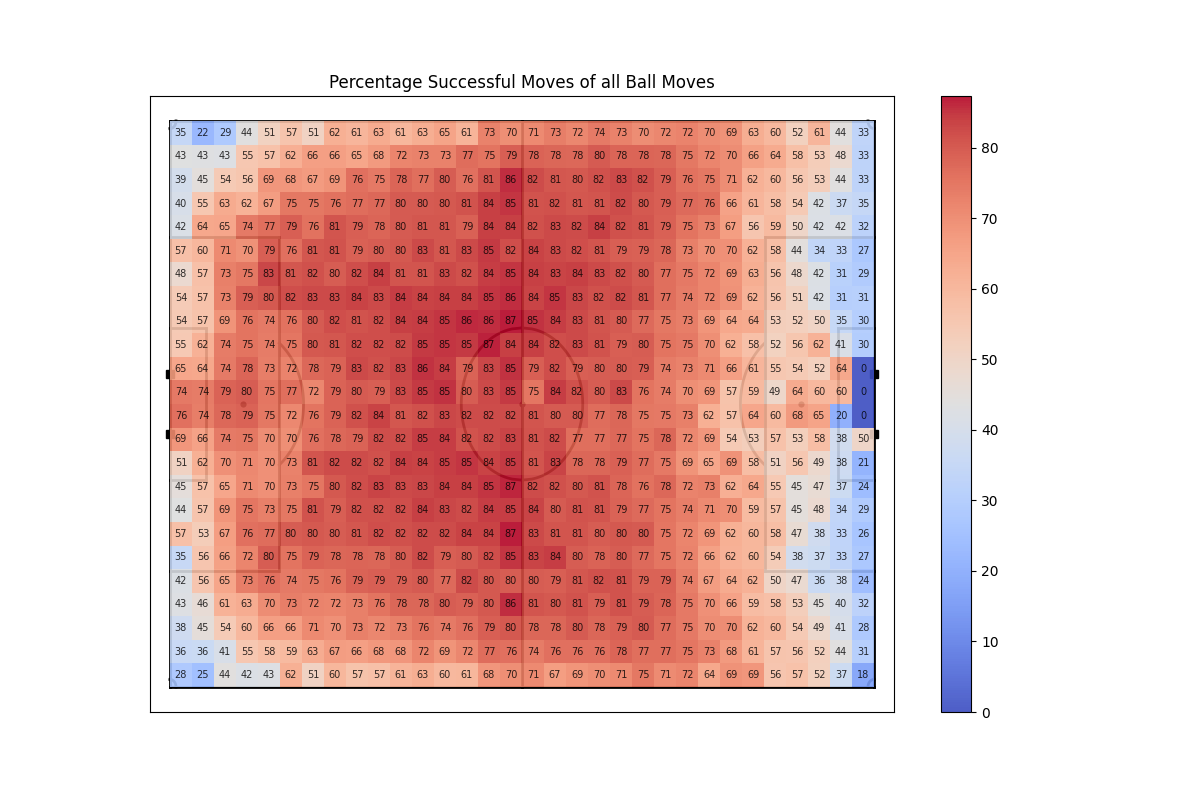

In [20]:
for title, data in zip(titles[3:], ratios[3:]):
    plot_results(data.ravel(), title=title, add_text=True)

The percentage of ball moves over all events is, of course, the inverse of the percentage of shots over all events. In general wee see a sucess rate of actions of about 80%, with higher values on ones own half, and lower values near either backline. Especially the lower success rate at ones own back line is interesting. It is likely that teams primarily get in possession there when they are highly pressured or just captured the ball and blindly shoot the ball forward (clearance) which might somethimes be labelled as a failed pass by event data providers.

## xT Defined

Expected Threat is a very intuitive idea. It basically takes the probability of shooting from a given location and multiplies it with the expected goals value, and adds the probability of moving the ball to any other location of the pitch and multiplies that times the expected threat value of that location. In a formula it looks something like this:

$ xT(x, y) = P_{shot}(x, y) * xG(x, y) + \sum \limits _{z=1} ^{x\_cells} \sum \limits _{w=1} ^{y\_cells} P_{move}(x, y -> z, w) * xT(z, w) $

Which can be simplified to:

$ xT(x, y) = P_{shot}(x, y) * xG(x, y) + P_{move} * T_{moves}(x, y) * xT $

Where $ P_{shot} $ and $ P_{move} $ are the probability of a shot and the probability of a successful ball move (pass or dribble) respectively, $ xG $ is the expected goals model and $ T_{moves}(x, y) $ is, given that a move is successfull from the current position, the likelyhood of where the ball will go next.

## Creating the Transition Matrices

Now we need for every cell in the grid a transition matrix. The transition matrix holds the ratios of where a successful pass is likely to go. We ravel the grid to get an squared 2d array of N_X_BINS * N_Y_BINS by N_X_BINS * N_Y_BINS. In this loop we also fill an xG matrix, with the xG value for every cell.

In [21]:
succ_move_probs = np.zeros((N_X_BINS * N_Y_BINS, N_X_BINS * N_Y_BINS))
xg_vals = np.zeros(N_X_BINS * N_Y_BINS)

xg_model = joblib.load("../databallpy/models/xG_by_foot_pipeline.pkl")
cell_id = 0
for x_start1, x_start2 in zip(x_edges[:-1], x_edges[1:]):
    # df of all events that are within the x range
    start_df_x = df[((df["start_x"] >= x_start1) & (df["start_x"] <= x_start2))]
    for y_start1, y_start2 in zip(y_edges[:-1], y_edges[1:]):
        # df of all events that are within the x and the y range
        start_df = start_df_x[((start_df_x["start_y"] >= y_start1) & (start_df_x["start_y"] <= y_start2))]
        succ_mask = (~start_df["end_x"].isnull()) & (~start_df["end_y"].isnull()) & (start_df["event"]!="shot") & (start_df["successful"]==1)
        hist_ball_moves_succ_current_pos, _, _ = np.histogram2d(start_df.loc[succ_mask, "end_x"], start_df.loc[succ_mask, "end_y"], **params)
        current_ratio = hist_ball_moves_succ_current_pos / len(start_df)
        succ_move_probs[cell_id] = current_ratio.ravel()

        # Fill xG array
        loc = np.array([np.mean([x_start1, x_start2]), np.mean([y_start1, y_start2])])
        goal_distance = np.sqrt(np.power(X_RANGE[1] - loc[0], 2) + np.power(loc[1], 2))
        shot_angle = get_smallest_angle(loc - np.array([X_RANGE[1], 3.63]), loc - np.array([X_RANGE[1], -3.66]), angle_format="degree")
        xg_vals[cell_id] = xg_model.predict_proba(np.array([[goal_distance, shot_angle]]))[0, 1]

        cell_id += 1        

In [22]:
def get_mirrored_index(index, n_rows=N_X_BINS, n_cols=N_Y_BINS):
    x_idx = index // n_cols
    x_mean_idx = (n_rows-1) / 2 
    x_diff = np.abs(x_mean_idx - x_idx)
    if x_idx > x_mean_idx:
        x_idx -= (2*x_diff) 
    else:
        x_idx += (2*x_diff) 

    y_idx = index % n_cols
    y_mean_idx = (n_cols-1) / 2 
    y_diff = np.abs(y_mean_idx - y_idx)
    if y_idx > y_mean_idx:
        y_idx -= (2*y_diff) 
    else:
        y_idx += (2*y_diff) 

    return int(x_idx*n_cols + y_idx)

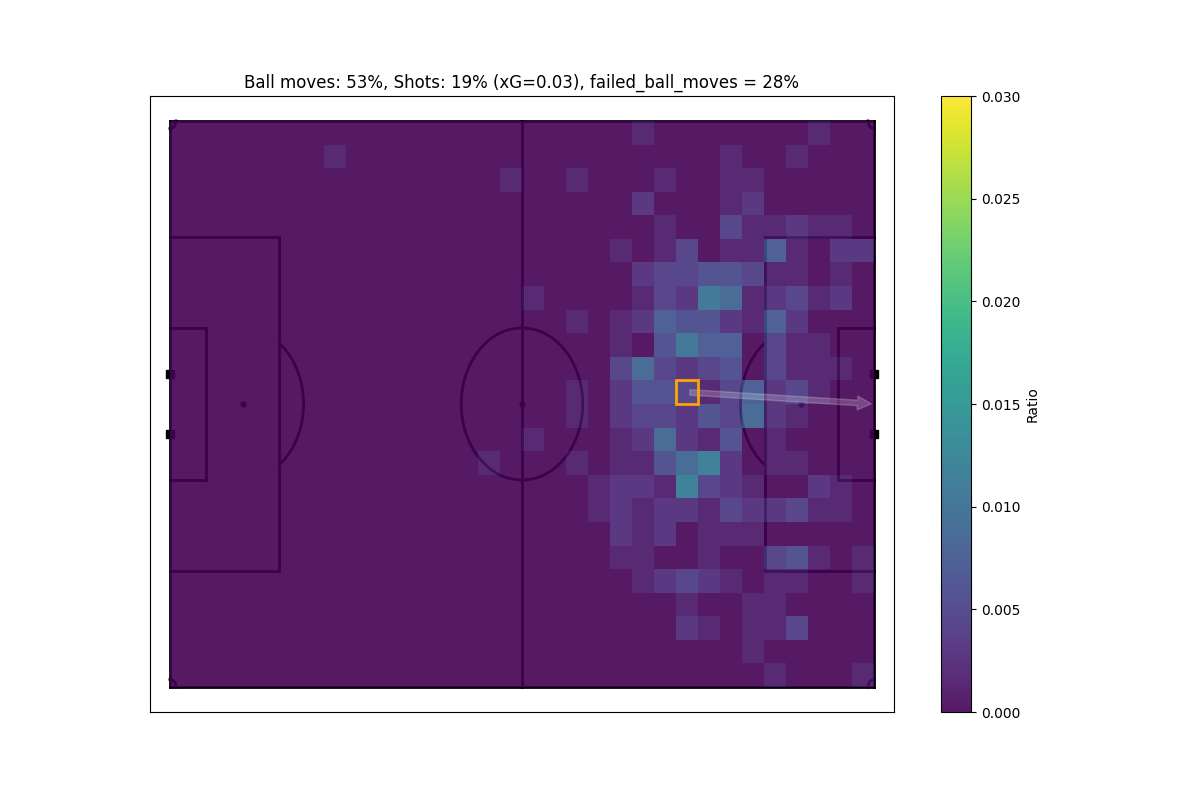

In [23]:
%matplotlib widget

box_width = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
box_height = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

idx = int(N_Y_BINS * (N_X_BINS - int(0.3*N_X_BINS)) + (0.5 * N_Y_BINS))
x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height



plt.close("all")
fig, ax = plot_soccer_pitch(pitch_color="white")
ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.03)
fig.colorbar(pcm, ax=ax, label="Ratio")

goal_loc = (53.0, 0)
arrow = mpatches.FancyArrowPatch((x1 + 0.5 * box_width, y1 + 0.5 * box_height), goal_loc,
                                 mutation_scale=20)
arrow.set_alpha(ratio_shots.ravel()[idx])
arrow.set_color("white")
ax.add_patch(arrow)

ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
ratio_shot = int(ratio_shots.ravel()[idx] *100)
xg = round(xg_vals[idx], 2)
ratio_failed_ball_move = (100 - ratio_suc_ball_move_per - ratio_shot)

ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: {ratio_shot}% (xG={xg}), failed_ball_moves = {ratio_failed_ball_move}%")
rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
ax.add_patch(rec)
fig.canvas.draw_idle()


pitch_size = (X_RANGE[1] - X_RANGE[0], Y_RANGE[1] - Y_RANGE[0])
add_mirrored_index = False
def on_click(event):
    if event.inaxes == ax:

        [col.remove() for col in ax.collections]
        [patch.remove() for patch in ax.patches]
        [text.remove() for text in ax.texts]
        
        x = event.xdata
        y = event.ydata
        x_idx = np.floor((x + X_RANGE[1]) / (pitch_size[0] / N_X_BINS))
        y_idx = np.floor((y + Y_RANGE[1]) / (pitch_size[1] / N_Y_BINS))
        idx = int(x_idx * N_Y_BINS + y_idx)
        ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
        pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.03)
        
        x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
        y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height
        rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
        ax.add_patch(rec)

        if add_mirrored_index:
            mirrored_index = get_mirrored_index(idx)
            x2 = X_RANGE[0] + (mirrored_index // N_Y_BINS) * box_width
            y2 = Y_RANGE[0] + (mirrored_index % N_Y_BINS) * box_height
            rec = Rectangle((x2, y2), width=box_width, height=box_height, color='red', fc='none', lw=2)
            ax.add_patch(rec)
        
        ax.scatter([x], [y], color="black")
        
        arrow = mpatches.FancyArrowPatch((x , y), goal_loc, mutation_scale = 20)
        arrow.set_alpha(ratio_shots.ravel()[idx])
        arrow.set_color("white")
        ax.add_patch(arrow)
        
        ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
        ratio_shot = int(ratio_shots.ravel()[idx] *100)
        xg = round(xg_vals[idx], 2)
        ratio_failed_ball_move = (100 - ratio_suc_ball_move_per - ratio_shot)
        
        ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: {ratio_shot}% (xG={xg}), failed_ball_moves = {ratio_failed_ball_move}%")
        ax.axes()
            

        fig.canvas.draw_idle()
fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

For this position, you can see that on average, the ball is moved successfully in 53% of cases, in 19% of cases there is a shot, of which 3% result in a goal, and 28% of tried ball moves are unscussefull.

## Creating xT

You might have noticed that in the formula, the xT of one position is dependend on the xT of all other positions. So how do you solve the equation? There is no absolute way to get to the values, but Karun Singh found out that you can solve the equation iteratively. You start by initializing all xT values on the pitch at 0. After the first iteration, all values are equal to the xG values of that position. After all, passing the ball to another location gives an xT of zero (the initialised values). However, since the values change over time due to the xG, after about 5 iterations the model converges, they don't really change values anymore and reach a stable state.

Lets have a look of how that looks in Python:

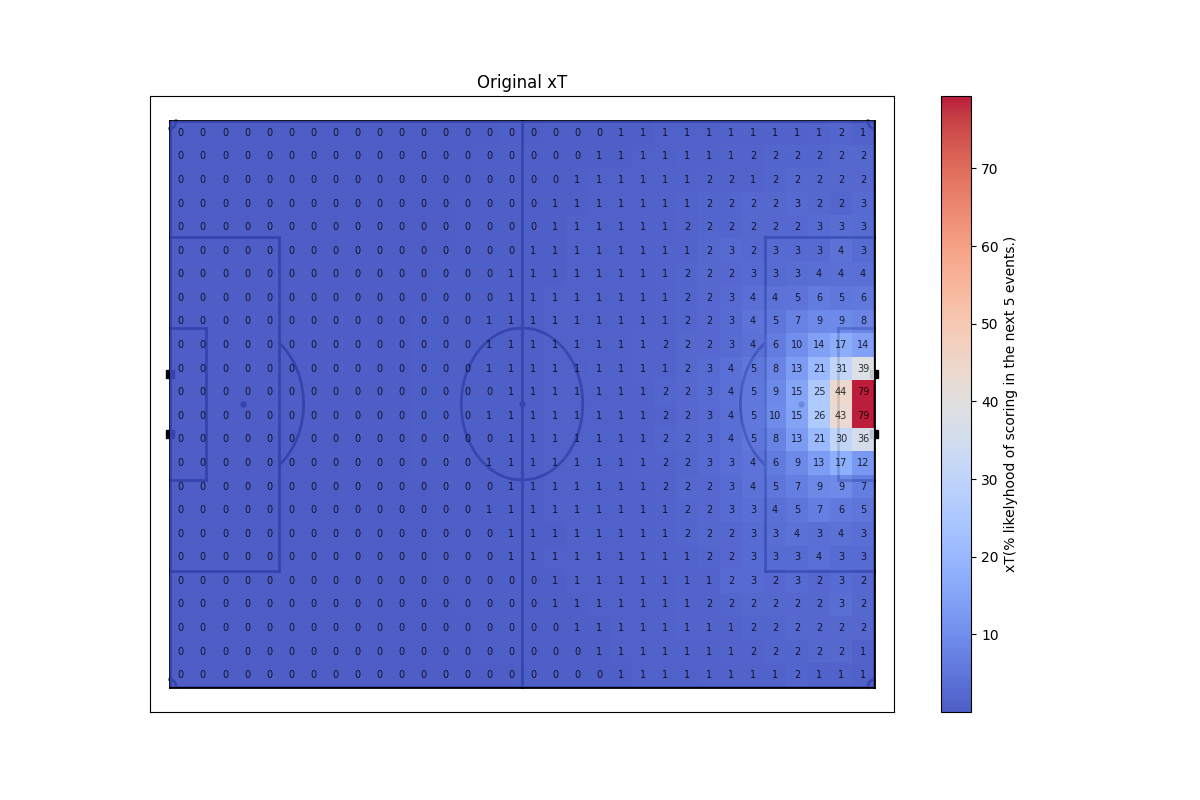

In [24]:
plt.close("all")

original_xT = np.zeros(N_X_BINS * N_Y_BINS)
next_xT = original_xT.copy()

# Iterations to converge the model
for i in range(7):

    # Loop over all possible location where you can have the ball
    for current_cell_id in range(len(original_xT)):

        # Given the current location, update the xT with the probability of a shot times the xG value of that shot
        current_cell_xT =  xg_vals[current_cell_id] * ratio_shots.ravel()[current_cell_id] 

        # Loop over all possible ball move options, and their likelyhood of happening successfully
        for to_cell_id in range(len(original_xT)):

            # Update the xT with the probability of a successful ball move times the xT of that end location
            current_cell_xT += succ_move_probs[current_cell_id, to_cell_id] * original_xT[to_cell_id]

        # Save the new xT of the current position
        next_xT[current_cell_id] = current_cell_xT

    # Update the original xT for the next iteration
    original_xT = next_xT.copy()

plot_results(original_xT, title="Original xT", label="xT(% likelyhood of scoring in the next 5 events.)" )

And there it is, the xT model for open play! A few things are notably. Firstly, it looks pretty simatrical from left to right. It values positions in the centre of the pitch higher than the sides, and it values proximity to the goal higher than distant cells. I think these are very intuitive results. We can now value for every position the xT by putting them in a cell on the pitch. However, as you can see, this would mean that there is never a xt value of 0.6, since no of the cells are anywhere near 60. Since the model is quite simatrical, we can create a linear regression to predict the values of the cells, so we can generalise to any location on the pitch:

Root Mean Square Error of the model is:  0.007


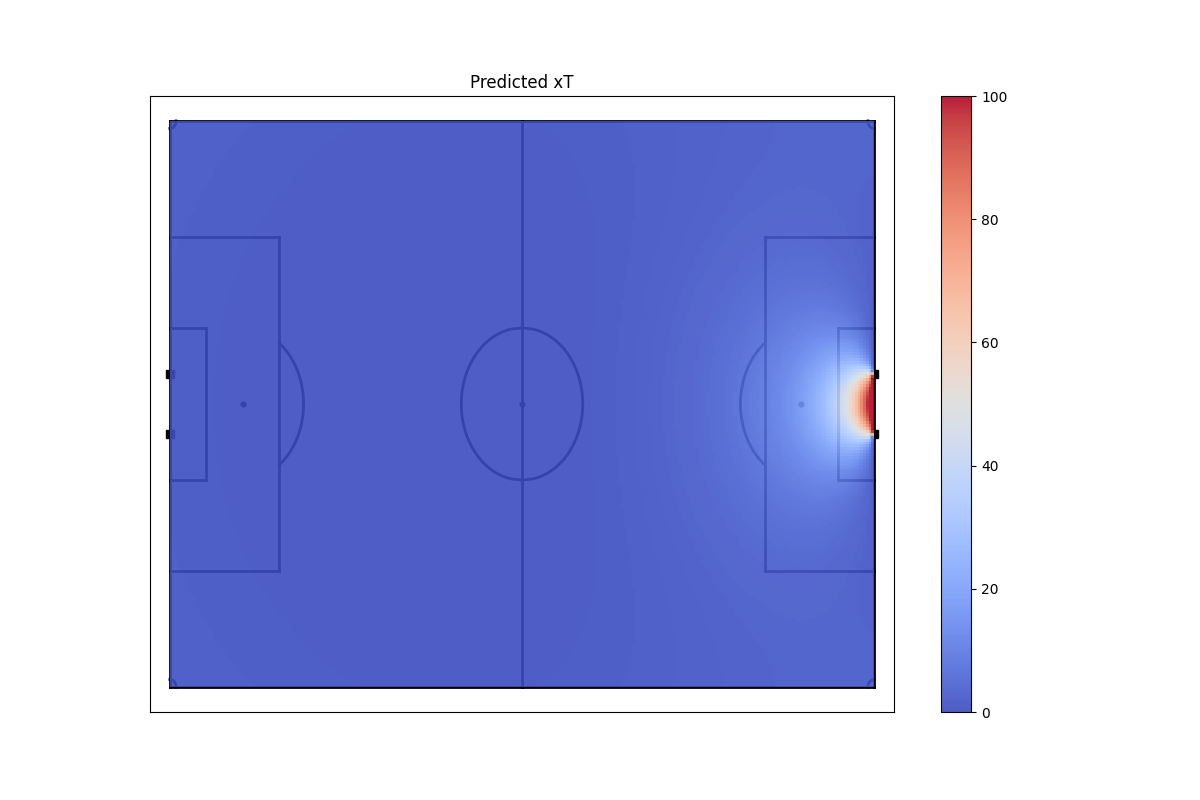

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

goal_loc = np.array([53., 0.])
left_post = np.array([53., 3.66])
right_post = np.array([53., -3.66])

distances = np.zeros(original_xT.shape)
angles = np.zeros(original_xT.shape)

for idx in range(len(original_xT)):
    x = (idx // N_Y_BINS + 0.5) * cell_length - 53
    y = (idx % N_Y_BINS + 0.5) * cell_width - 34
    distances[idx] = math.dist(np.array([x, y]), goal_loc)
    angles[idx] = get_smallest_angle(np.array([x, y]) - left_post, np.array([x, y]) - right_post, angle_format="degree")


norm_dist = distances/distances.max()
norm_ang = angles/angles.max()
norm_distang = (distances*angles)/(distances*angles).max()
X = np.array([norm_ang, norm_dist, norm_distang]).T
y = original_xT.copy()

lr_xt_open_play = LinearRegression()
lr_xt_open_play.fit(X, y)
print("Root Mean Square Error of the model is: ", np.sqrt(mean_squared_error(y, lr_xt_open_play.predict(X))).round(3))

distances_2 = np.zeros(256*196)
angles_2 = np.zeros(256*196)
for idx in range(256*196):
    x = (idx // 196 + 0.5) * (106/256) - 53
    y = (idx % 196 + 0.5) * (68/196) - 34
    distances_2[idx] = math.dist(np.array([x, y]), goal_loc)
    angles_2[idx] = get_smallest_angle(np.array([x, y]) - left_post, np.array([x, y]) - right_post, angle_format="degree")

X = np.array([angles_2/angles.max(), distances_2/distances.max(), (angles_2*distances_2)/(distances*angles).max()]).T

output = lr_xt_open_play.predict(X)
_, x_edges2, y_edges2 = np.histogram2d(df['start_x'], df['start_y'], bins=(256, 196), range=[X_RANGE, Y_RANGE])
plot_results(np.clip(output, a_max=1.0, a_min=0.0), title="Predicted xT", x_edges_func=x_edges2, y_edges_func=y_edges2, n_x_bins_func=256, n_y_bins_func=196, add_text=False)

## Evaluating the model

But to what extend does the model actually hold true to its promis to give the ratio of goals scored within the next 5 events?

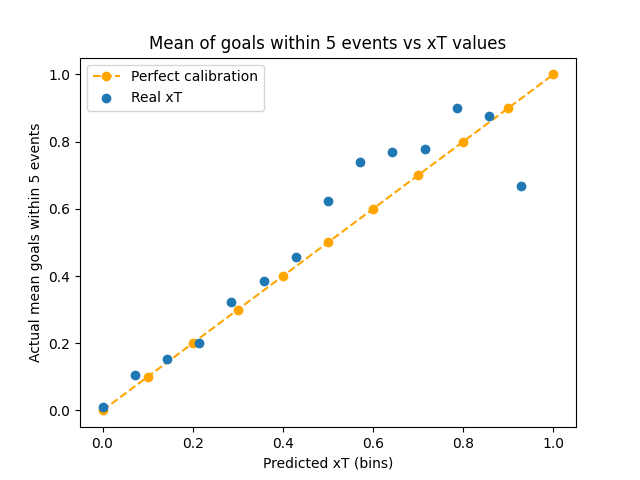

In [26]:
goal_within_5_events = (df["n_events_next_goal"] < 5).fillna(0)
dist_ang_max = (distances*angles).max()


x, y = df["start_x"].values, df["start_y"].values

real_distances = np.linalg.norm(goal_loc - np.array([x, y]).T, axis=1)
real_angles = get_smallest_angle(np.array([x, y]).T - left_post, np.array([x, y]).T - right_post, angle_format="degree")
real_dist_angles = real_distances * real_angles

X = np.array([real_angles/angles.max(), real_distances/distances.max(), real_dist_angles/(distances*angles).max()]).T
xt_values = np.clip(lr_xt_open_play.predict(X), a_min=0.0, a_max=1.0)

bins = np.linspace(xt_values.min(), xt_values.max(), 15)
bin_indices = np.digitize(xt_values, bins)
bin_means = [np.nanmean(np.array(goal_within_5_events)[bin_indices == i]) for i in range(1, len(bins))]
plt.close("all")
fig, ax = plt.subplots()

ax.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), marker="o", label="Perfect calibration", linestyle='--', color="orange", zorder=-1)
ax.scatter(bins[:-1], bin_means, label="Real xT")
ax.set_xlabel('Predicted xT (bins)')
ax.set_ylabel('Actual mean goals within 5 events')
ax.set_title('Mean of goals within 5 events vs xT values')
ax.legend()
plt.show()

That looks pretty decent. There are of course far less events with a high xT value, so it is harder to evaluate those and noise might play a bigger role. That being said, it seems to model the probabilities almost perfect up and until 0.5, which accounts for over 99 % of all pitch locations. For the higher values, it seems to be struggling a bit, but because there are only very few instances where values higher than .5 are predicted (162 of about 600000 events (0.02%)), I think this is a very decent outcome.

Note that there are two major shortcomming with this method. Firstly, it is not capable of valuing defensive actions. The model is possession based and therefore assumes that you will keep possession of the ball. Secondly, the model only utilizes the location of the ball. This of course over simplifies the complexity of what is happening on the pitch. An example of an improvement is the model developed by Greg Everett et al (2022) who created a [contextualized xT](https://statsbomb.com/wp-content/uploads/2023/03/Gregory-Everett-et-al-Contextual-xT-using-Spatial-Event-Data.pdf).

That begin said, lets save the model to make sure anyone can use the xT model in the future!

In [27]:
import joblib

save_dir = "../databallpy/models"
# joblib.dump(lr_xt_open_play, f"{save_dir}/xt_open_play.pkl")
print(f"distance_max: {distances.max()}, angles_max = {angles.max()}, dist_ang_max = {(distances*angles).max()}")

def get_open_play_xt(x:float, y:float):
    distance_max = 109.31281615242382
    angles_max = 125.49280975966289
    dist_ang_max = 419.19475190659335

    distance = math.dist([53, 0], [x, y])
    angle = get_smallest_angle(np.array([x, y]).T - left_post, np.array([x, y]).T - right_post, angle_format="degree")
    X = np.array([[angle/angles_max, distance/distance_max, (distance*angle)/dist_ang_max]])
    return np.clip(lr_xt_open_play.predict(X), a_min=0.0, a_max=1.0)[0]

distance_max: 109.31281615242382, angles_max = 125.49280975966289, dist_ang_max = 419.19475190659335


## Now lets do the same for set pieces

In [28]:
df = pd.read_pickle("data/positions_goals_dataset2.pkl") # note this is a local dataset

# exclude own goals and goals scored from own half, probably an event data error
df = df[df["event"]!="own_goal"]
df = df[~((df["event"]=="shot") & (df["successful"]==1) & (df["start_x"] < 0))]
df_set_piece = df[df["set_piece"]!="no_set_piece"]
df_set_piece["set_piece"].value_counts()

set_piece
throw_in       25824
free_kick      13770
goal_kick       9770
corner_kick     6127
kick_off        2965
penalty          123
Name: count, dtype: int64

In [29]:
goal_within_5_events = (df_set_piece["n_events_next_goal"] < 5).fillna(0)

Kick offs, penalties, goal_kicks, and corner kicks are so extremely standardised and similar that we can take just take the percentage of times a goal is scored in within 5 events after that event.

In [30]:
kick_off_xt = goal_within_5_events[df_set_piece["set_piece"]=="kick_off"].sum() / (df_set_piece["set_piece"]=="kick_off").sum()
penalty_xt = goal_within_5_events[df_set_piece["set_piece"]=="penalty"].sum() / (df_set_piece["set_piece"]=="penalty").sum()
corner_xt = goal_within_5_events[df_set_piece["set_piece"]=="corner_kick"].sum() / (df_set_piece["set_piece"]=="corner_kick").sum()
goal_kick_xt = goal_within_5_events[df_set_piece["set_piece"]=="goal_kick"].sum() / (df_set_piece["set_piece"]=="goal_kick").sum()

print(f"Kick off xt: {round(kick_off_xt, 3)}, penalty xt: {round(penalty_xt, 3)}, corner xt: {round(corner_xt, 3)}, goal_kick: {round(goal_kick_xt, 2)}")

Kick off xt: 0.001, penalty xt: 0.797, corner xt: 0.042, goal_kick: 0.0


Looks about right, although I had expected the corner xt to be a bid higher, but might be my dataset or just a new truth about corners.

Now, for the throw_in and free_kick set_piece I think we need to create different models since the type of events are so different.

In [31]:
free_kicks = df_set_piece[df_set_piece["set_piece"]=="free_kick"]
throw_ins = df_set_piece[df_set_piece["set_piece"]=="throw_in"]

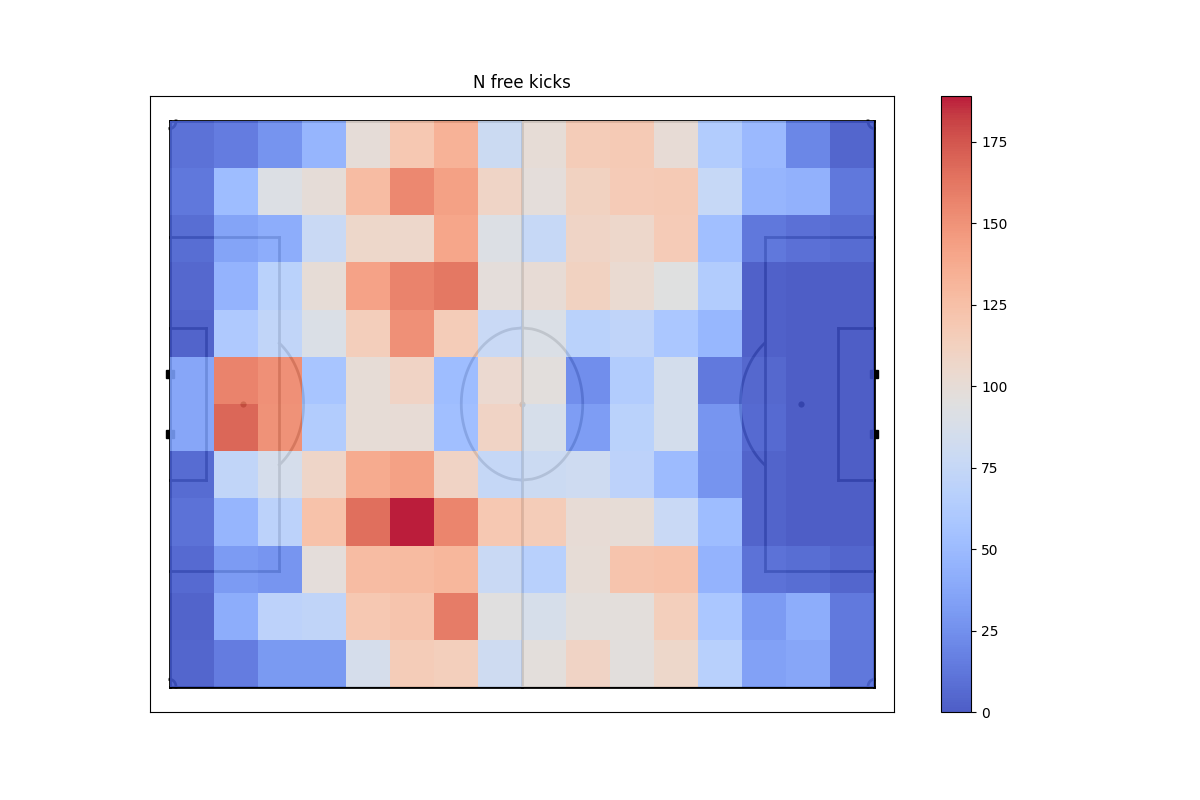

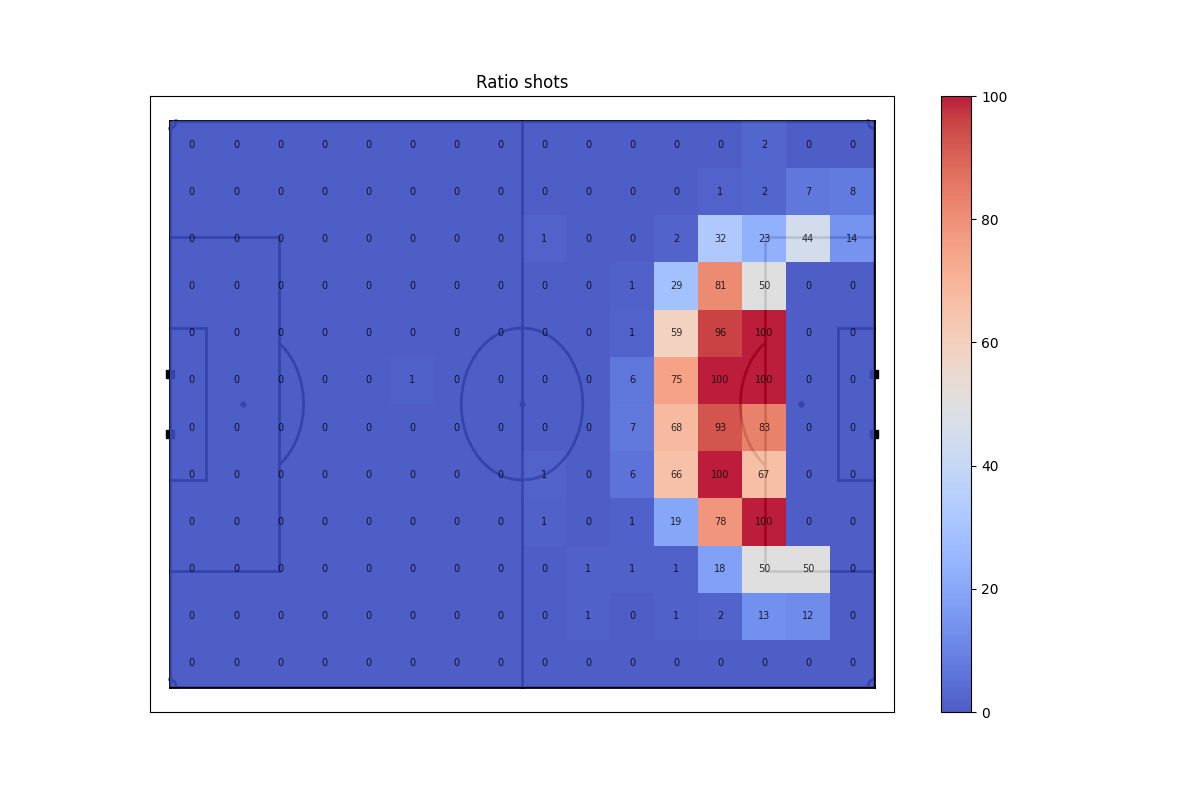

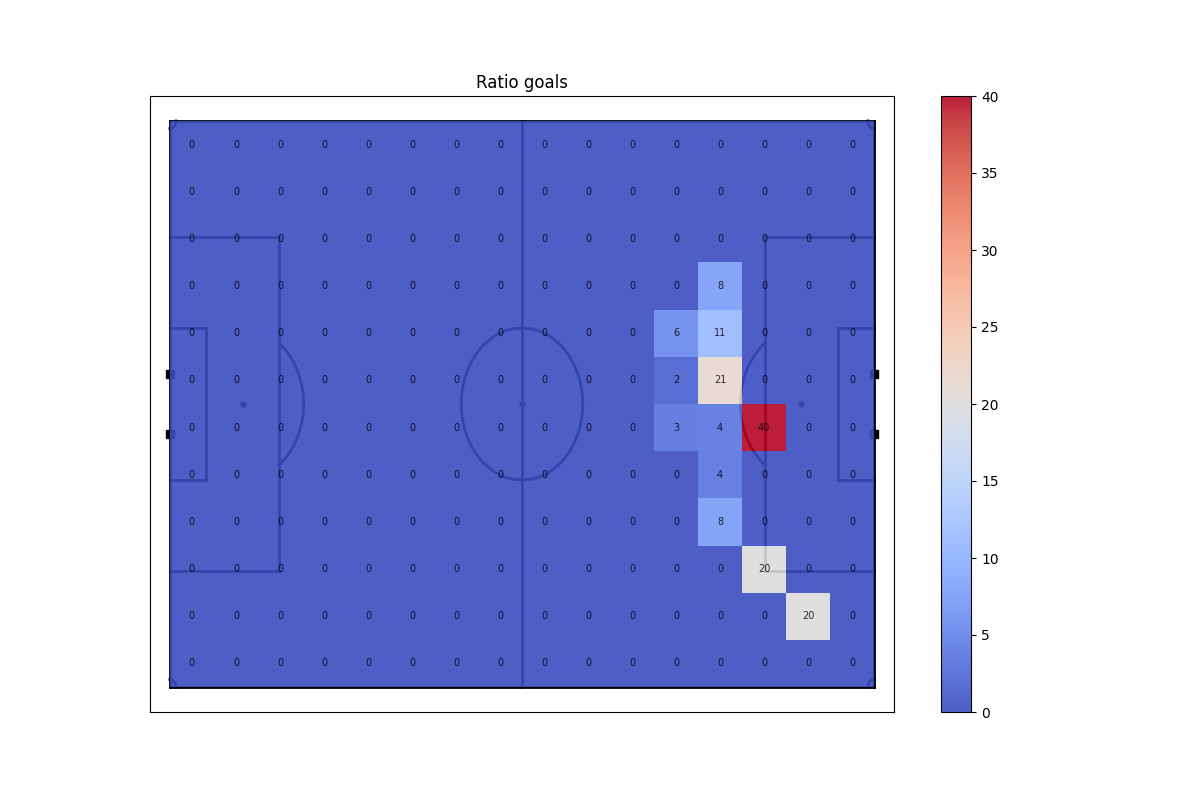

In [34]:
N_X_BINS = 16
N_Y_BINS = 12
X_RANGE = (-53, 53)
Y_RANGE = (-34, 34)
pitch_length = 106
pitch_width = 68
cell_length = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
cell_width = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

params = {"bins": (N_X_BINS, N_Y_BINS), "range": [X_RANGE, Y_RANGE]}

hist_events, x_edges, y_edges = np.histogram2d(free_kicks['start_x'], free_kicks['start_y'], **params)
hist_shots, _, _ = np.histogram2d(free_kicks.loc[free_kicks["event"]=="shot", 'start_x'], free_kicks.loc[free_kicks["event"]=="shot", 'start_y'], **params)
hist_goals, _, _ = np.histogram2d(
    free_kicks.loc[((free_kicks["event"]=="shot") & (free_kicks["successful"]==1)), 'start_x'], 
    free_kicks.loc[((free_kicks["event"]=="shot") & (free_kicks["successful"]==1)), 'start_y'], 
    **params
) 
hist_ball_moves, _, _ = np.histogram2d(free_kicks.loc[free_kicks["event"]!="shot", 'start_x'], free_kicks.loc[free_kicks["event"]!="shot", 'start_y'], **params)
hist_ball_moves_succ, _, _ = np.histogram2d(
    free_kicks.loc[((free_kicks["event"]!="shot") & (free_kicks["successful"]==1)), 'start_x'], 
    free_kicks.loc[((free_kicks["event"]!="shot") & (free_kicks["successful"]==1)), 'start_y'], 
    **params
)
ratio_shots = np.divide(hist_shots, hist_events, where=hist_events!=0)
ratio_goals = np.divide(hist_goals, hist_shots, where=hist_shots!=0)
ratio_ball_moves = np.divide(hist_ball_moves, hist_events, where=hist_events!=0)
ratio_ball_moves_succ = np.divide(hist_ball_moves_succ, hist_ball_moves, where=hist_ball_moves!=0)
ratio_failed_actions = 1 - (ratio_ball_moves * ratio_ball_moves_succ) - (ratio_shots * ratio_goals)

plot_results(hist_events.ravel()/100., title="N free kicks", add_text=False, )
plot_results(ratio_shots.ravel(), title="Ratio shots", add_text=True)
plot_results(ratio_goals.ravel(), title="Ratio goals", add_text=True)

In [35]:
succ_move_probs = np.zeros((N_X_BINS * N_Y_BINS, N_X_BINS * N_Y_BINS))
xg_vals = np.zeros(N_X_BINS * N_Y_BINS)

xg_model = joblib.load("../databallpy/models/xG_free_kick_pipeline.pkl")
cell_id = 0
for x_start1, x_start2 in zip(x_edges[:-1], x_edges[1:]):
    # df of all events that are within the x range
    start_df_x = free_kicks[((free_kicks["start_x"] >= x_start1) & (free_kicks["start_x"] <= x_start2))]
    for y_start1, y_start2 in zip(y_edges[:-1], y_edges[1:]):
        # df of all events that are within the x and the y range
        start_df = start_df_x[((start_df_x["start_y"] >= y_start1) & (start_df_x["start_y"] <= y_start2))]
        succ_mask = (~start_df["end_x"].isnull()) & (~start_df["end_y"].isnull()) & (start_df["event"]!="shot") & (start_df["successful"]==1)
        hist_ball_moves_succ_current_pos, _, _ = np.histogram2d(start_df.loc[succ_mask, "end_x"], start_df.loc[succ_mask, "end_y"], **params)
        if len(start_df) > 0:
            current_ratio = hist_ball_moves_succ_current_pos / len(start_df)
        else:
            current_ratio = np.zeros(hist_ball_moves_succ_current_pos.shape)
        succ_move_probs[cell_id] = current_ratio.ravel()

        # Fill xG array
        loc = np.array([np.mean([x_start1, x_start2]), np.mean([y_start1, y_start2])])
        goal_distance = np.sqrt(np.power(X_RANGE[1] - loc[0], 2) + np.power(loc[1], 2))
        shot_angle = get_smallest_angle(loc - np.array([X_RANGE[1], 3.63]), loc - np.array([X_RANGE[1], -3.66]), angle_format="degree")
        xg_vals[cell_id] = xg_model.predict_proba(np.array([[goal_distance, shot_angle]]))[0, 1]

        cell_id += 1     

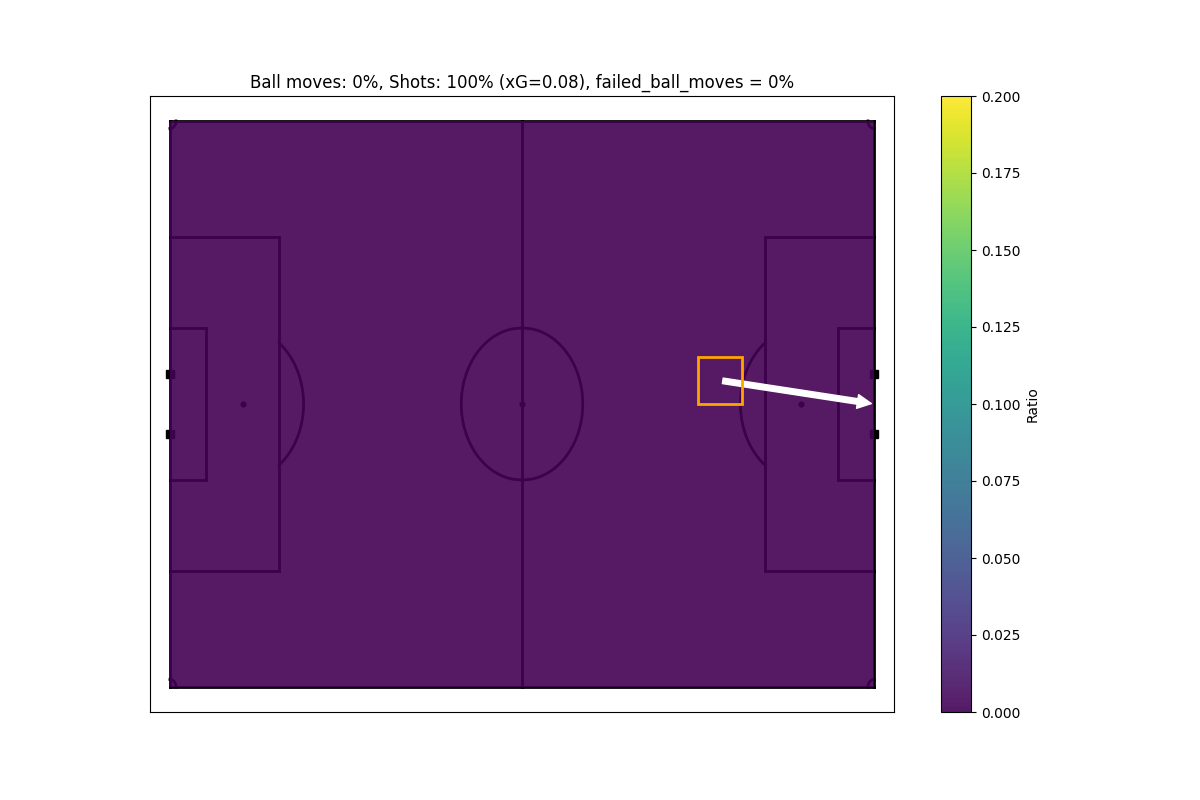

In [36]:
%matplotlib widget

box_width = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
box_height = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

idx = int(N_Y_BINS * (N_X_BINS - int(0.3*N_X_BINS)) + (0.5 * N_Y_BINS))
x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height

plt.close("all")
fig, ax = plot_soccer_pitch(pitch_color="white")
ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.2)
fig.colorbar(pcm, ax=ax, label="Ratio")

goal_loc = (53.0, 0)
arrow = mpatches.FancyArrowPatch((x1 + 0.5 * box_width, y1 + 0.5 * box_height), goal_loc,
                                 mutation_scale=20)
arrow.set_alpha(ratio_shots.ravel()[idx])
arrow.set_color("white")
ax.add_patch(arrow)

ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
ratio_shot = int(ratio_shots.ravel()[idx] *100)
xg = round(xg_vals[idx], 2)
ratio_failed_ball_move = (100 - ratio_suc_ball_move_per - ratio_shot)

ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: {ratio_shot}% (xG={xg}), failed_ball_moves = {ratio_failed_ball_move}%")
rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
ax.add_patch(rec)
fig.canvas.draw_idle()


pitch_size = (X_RANGE[1] - X_RANGE[0], Y_RANGE[1] - Y_RANGE[0])
add_mirrored_index = False
def on_click(event):
    if event.inaxes == ax:

        [col.remove() for col in ax.collections]
        [patch.remove() for patch in ax.patches]
        [text.remove() for text in ax.texts]
        
        x = event.xdata
        y = event.ydata
        x_idx = np.floor((x + X_RANGE[1]) / (pitch_size[0] / N_X_BINS))
        y_idx = np.floor((y + Y_RANGE[1]) / (pitch_size[1] / N_Y_BINS))
        idx = int(x_idx * N_Y_BINS + y_idx)
        ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
        pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.2)
        
        x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
        y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height
        rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
        ax.add_patch(rec)

        if add_mirrored_index:
            mirrored_index = get_mirrored_index(idx)
            x2 = X_RANGE[0] + (mirrored_index // N_Y_BINS) * box_width
            y2 = Y_RANGE[0] + (mirrored_index % N_Y_BINS) * box_height
            rec = Rectangle((x2, y2), width=box_width, height=box_height, color='red', fc='none', lw=2)
            ax.add_patch(rec)
        
        ax.scatter([x], [y], color="black")
        
        arrow = mpatches.FancyArrowPatch((x , y), goal_loc, mutation_scale = 20)
        arrow.set_alpha(ratio_shots.ravel()[idx])
        arrow.set_color("white")
        ax.add_patch(arrow)
        
        ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
        ratio_shot = int(ratio_shots.ravel()[idx] *100)
        xg = round(xg_vals[idx], 2)
        ratio_failed_ball_move = (100 - ratio_suc_ball_move_per - ratio_shot)
        
        ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: {ratio_shot}% (xG={xg}), failed_ball_moves = {ratio_failed_ball_move}%")
        ax.axes()
            

        fig.canvas.draw_idle()
fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

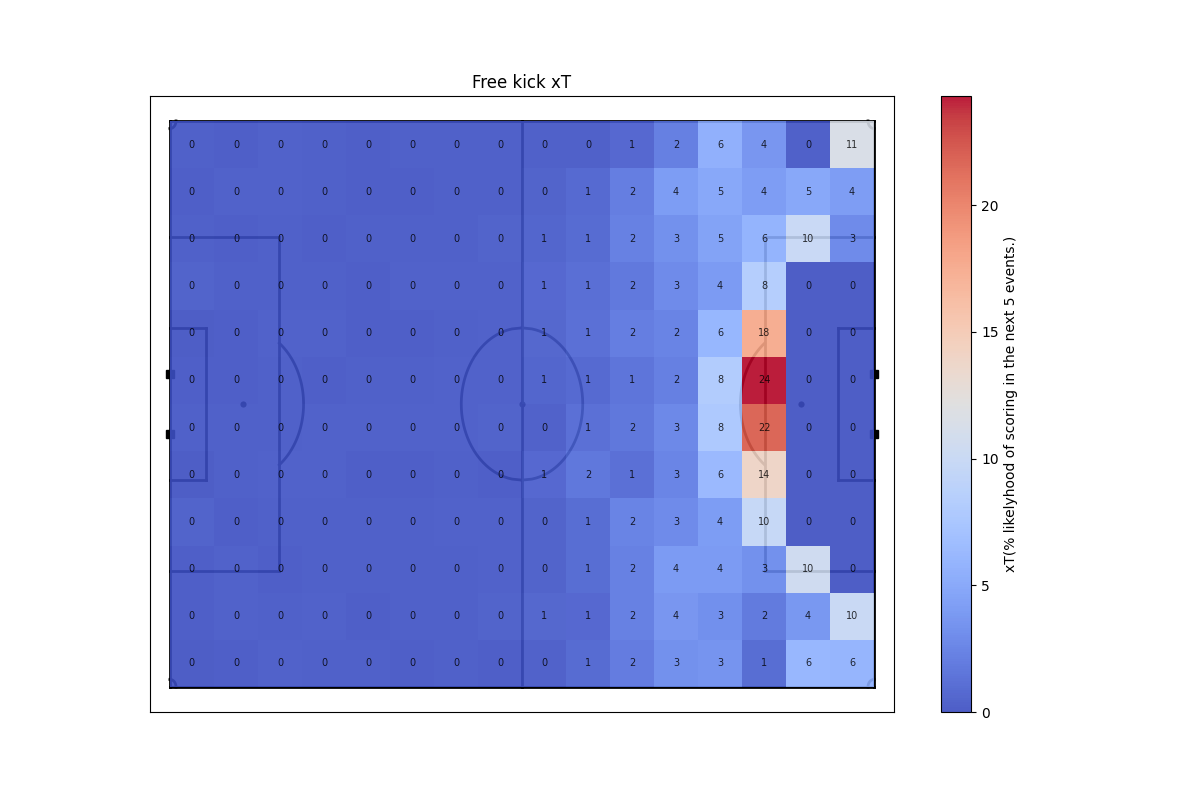

In [37]:
plt.close("all")

free_kick_xT = np.zeros(N_X_BINS * N_Y_BINS)
open_play_xT_grid = np.zeros(N_X_BINS * N_Y_BINS)
for cell in range(len(open_play_xT_grid)):
    x = (cell // N_Y_BINS + 0.5) * cell_length - 53
    y = (cell % N_Y_BINS + 0.5) * cell_width - 34
    open_play_xT_grid[cell] = get_open_play_xt(x, y)

# Loop over all possible location where you can have the ball
for current_cell_id in range(len(free_kick_xT)):

    # Given the current location, update the xT with the probability of a shot times the xG value of that shot
    current_cell_xT =  xg_vals[current_cell_id] * ratio_shots.ravel()[current_cell_id] 

    # Loop over all possible ball move options, and their likelyhood of happening successfully
    for to_cell_id in range(len(free_kick_xT)):
        x = (to_cell_id // N_Y_BINS + 0.5) * cell_length - 53
        y = (to_cell_id % N_Y_BINS + 0.5) * cell_width - 34
        

        # Update the xT with the probability of a successful ball move times the xT of that end location in open play
        current_cell_xT += succ_move_probs[current_cell_id, to_cell_id] * open_play_xT_grid[to_cell_id]
    # Save the new xT of the current position
    free_kick_xT[current_cell_id] = current_cell_xT

plot_results(free_kick_xT, title="Free kick xT", label="xT(% likelyhood of scoring in the next 5 events.)" )

Root Mean Square Error of the model is:  0.013


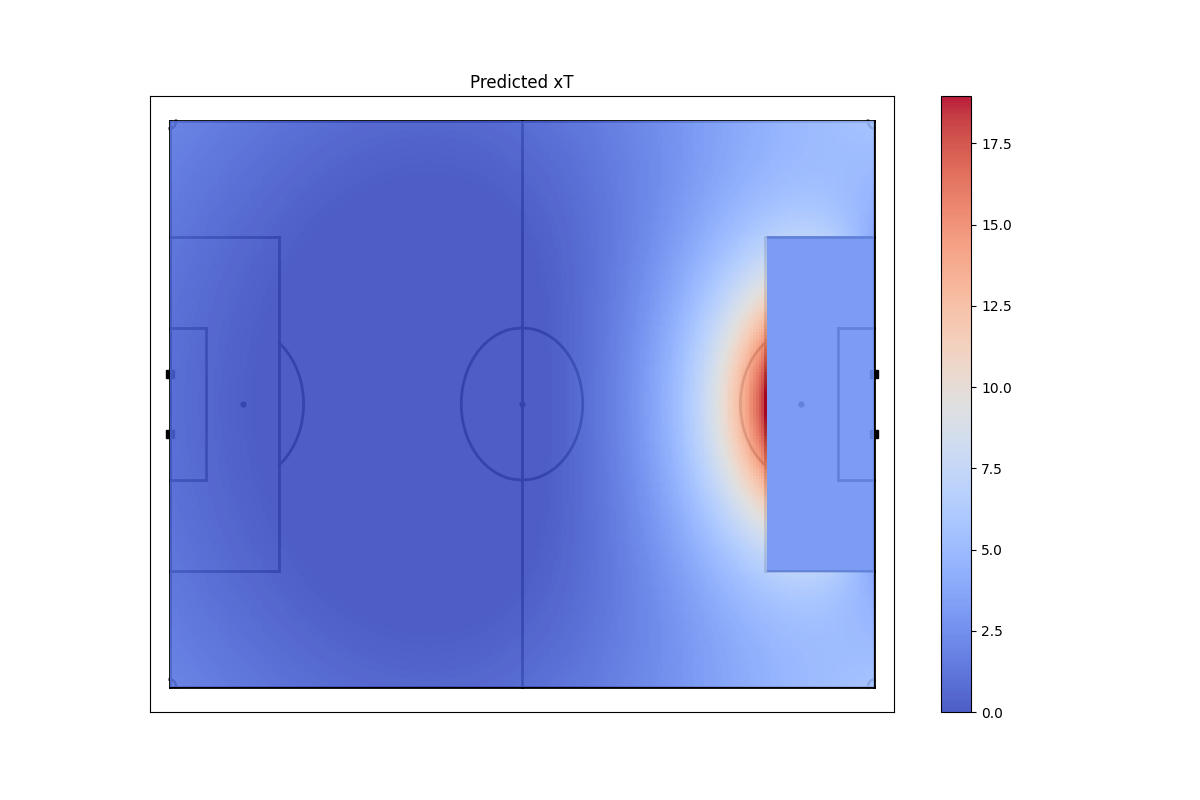

In [38]:
distances = np.zeros(free_kick_xT.shape)
angles = np.zeros(free_kick_xT.shape)

for idx in range(len(free_kick_xT)):
    x = (idx // N_Y_BINS + 0.5) * cell_length - 53
    y = (idx % N_Y_BINS + 0.5) * cell_width - 34
    if (np.abs(y) < 20.5) & (x > 37):
        distances[idx] = np.nan
        angles[idx] = np.nan
    else:
        distances[idx] = math.dist(np.array([x, y]), goal_loc)
        angles[idx] = get_smallest_angle(np.array([x, y]) - left_post, np.array([x, y]) - right_post, angle_format="degree")
        if pd.isnull(angles[idx]):
            print(x, y)

to_keep_idxs = np.where(~pd.isnull(distances))[0]
angles = angles[to_keep_idxs]
distances = distances[to_keep_idxs]


norm_dist = distances/distances.max()
norm_ang = angles/angles.max()
norm_distang = (distances*angles)/(distances*angles).max()
X = np.array([norm_ang, norm_dist, norm_distang]).T
y = free_kick_xT[to_keep_idxs].copy()

lr_xt_free_kick = LinearRegression()
lr_xt_free_kick.fit(X, y)
print("Root Mean Square Error of the model is: ", np.sqrt(mean_squared_error(y, lr_xt_free_kick.predict(X))).round(3))

distances_2 = np.zeros(256*196)
angles_2 = np.zeros(256*196)
for idx in range(256*196):
    x = (idx // 196 + 0.5) * (106/256) - 53
    y = (idx % 196 + 0.5) * (68/196) - 34
    if (np.abs(y) < 20.) & (x > 37):
        distances_2[idx] = 50
        angles_2[idx] = 5
    else:
        distances_2[idx] = math.dist(np.array([x, y]), goal_loc)
        angles_2[idx] = get_smallest_angle(np.array([x, y]) - left_post, np.array([x, y]) - right_post, angle_format="degree")

X = np.array([angles_2/angles.max(), distances_2/distances.max(), (angles_2*distances_2)/(distances*angles).max()]).T

output = lr_xt_free_kick.predict(X)
_, x_edges2, y_edges2 = np.histogram2d(df['start_x'], df['start_y'], bins=(256, 196), range=[X_RANGE, Y_RANGE])
plot_results(np.clip(output, a_max=1.0, a_min=0.0), title="Predicted xT", x_edges_func=x_edges2, y_edges_func=y_edges2, n_x_bins_func=256, n_y_bins_func=196, add_text=False)

/Users/alexander/Library/Caches/pypoetry/virtualenvs/databallpy-dxir0YXO-py3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alexander/Library/Caches/pypoetry/virtualenvs/databallpy-dxir0YXO-py3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


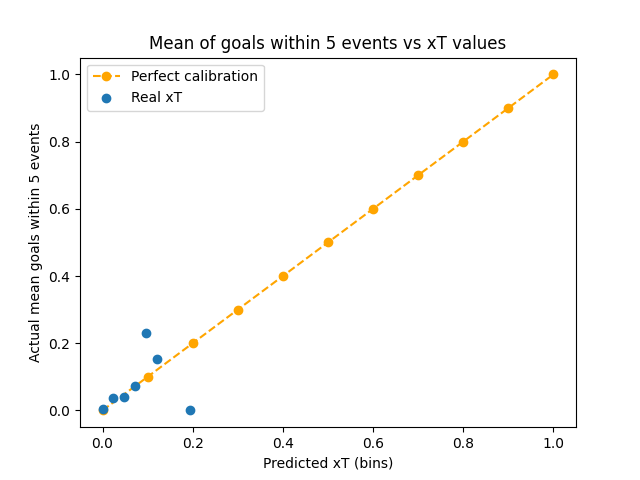

In [39]:
goal_within_5_events = (free_kicks["n_events_next_goal"] < 5).fillna(0)
dist_ang_max = (distances*angles).max()

x, y = free_kicks["start_x"].values, free_kicks["start_y"].values

real_distances = np.linalg.norm(goal_loc - np.array([x, y]).T, axis=1)
real_angles = get_smallest_angle(np.array([x, y]).T - left_post, np.array([x, y]).T - right_post, angle_format="degree")
real_dist_angles = real_distances * real_angles

X = np.array([real_angles/angles.max(), real_distances/distances.max(), real_dist_angles/(distances*angles).max()]).T
xt_values = np.clip(lr_xt_free_kick.predict(X), a_min=0.0, a_max=1.0)

bins = np.linspace(xt_values.min(), xt_values.max(), 10)
bin_indices = np.digitize(xt_values, bins)
bin_means = [np.nanmean(np.array(goal_within_5_events)[bin_indices == i]) for i in range(1, len(bins))]
plt.close("all")
fig, ax = plt.subplots()

ax.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), marker="o", label="Perfect calibration", linestyle='--', color="orange", zorder=-1)
ax.scatter(bins[:-1], np.array(bin_means), label="Real xT")
ax.set_xlabel('Predicted xT (bins)')
ax.set_ylabel('Actual mean goals within 5 events')
ax.set_title('Mean of goals within 5 events vs xT values')
ax.legend()
plt.show()

In [44]:
import joblib

def get_free_kick_xt(x:float, y:float):
    distance_max = 107.31301769757997
    angles_max = 24.265051087640582
    dist_ang_max = 419.0688265871174

    distance = math.dist([53, 0], [x, y])
    angle = get_smallest_angle(np.array([x, y]).T - left_post, np.array([x, y]).T - right_post, angle_format="degree")
    X = np.array([[angle/angles_max, distance/distance_max, (distance*angle)/dist_ang_max]])
    return np.clip(lr_xt_free_kick.predict(X), a_min=0.0, a_max=1.0)[0]


get_free_kick_xt(-37.8, -2.72) 

save_dir = "../databallpy/models"
joblib.dump(lr_xt_free_kick, f"{save_dir}/xt_free_kicks.pkl")
print(f"distance_max: {distances.max()}, angles_max = {angles.max()}, dist_ang_max = {(distances*angles).max()}")

distance_max: 107.31301769757997, angles_max = 24.265051087640582, dist_ang_max = 419.0688265871174


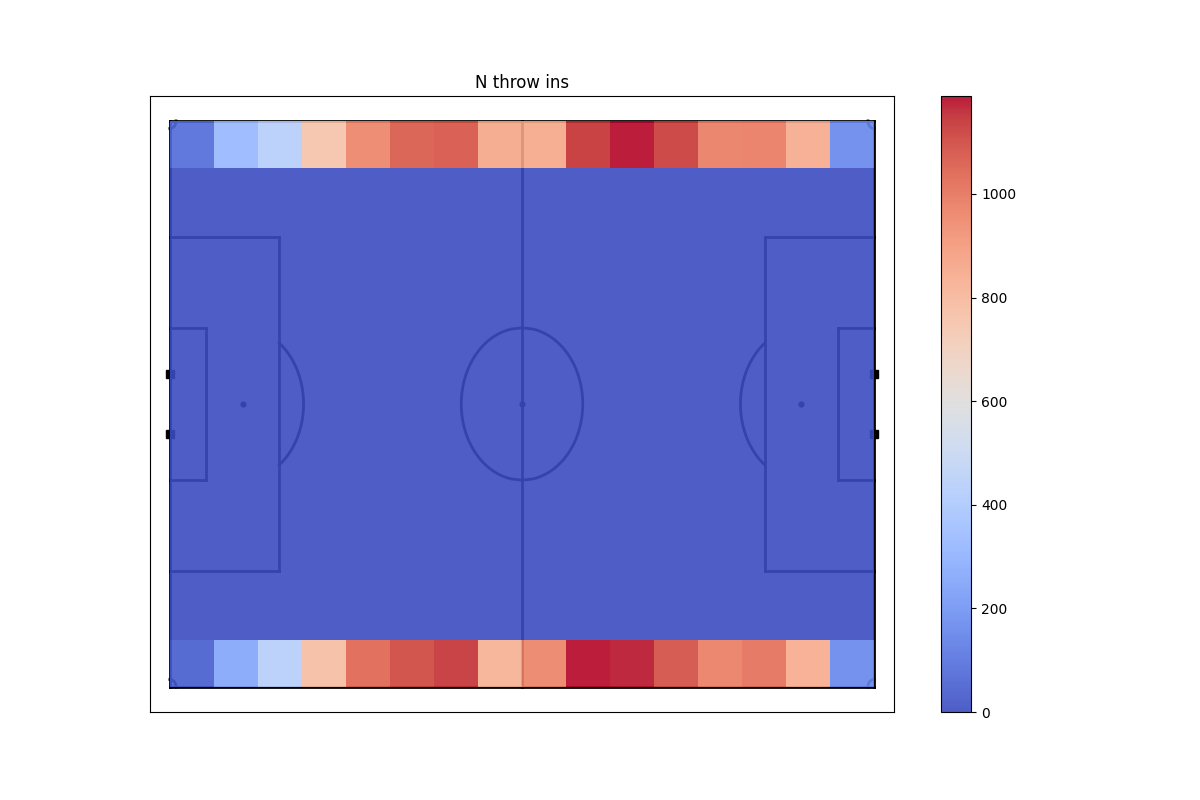

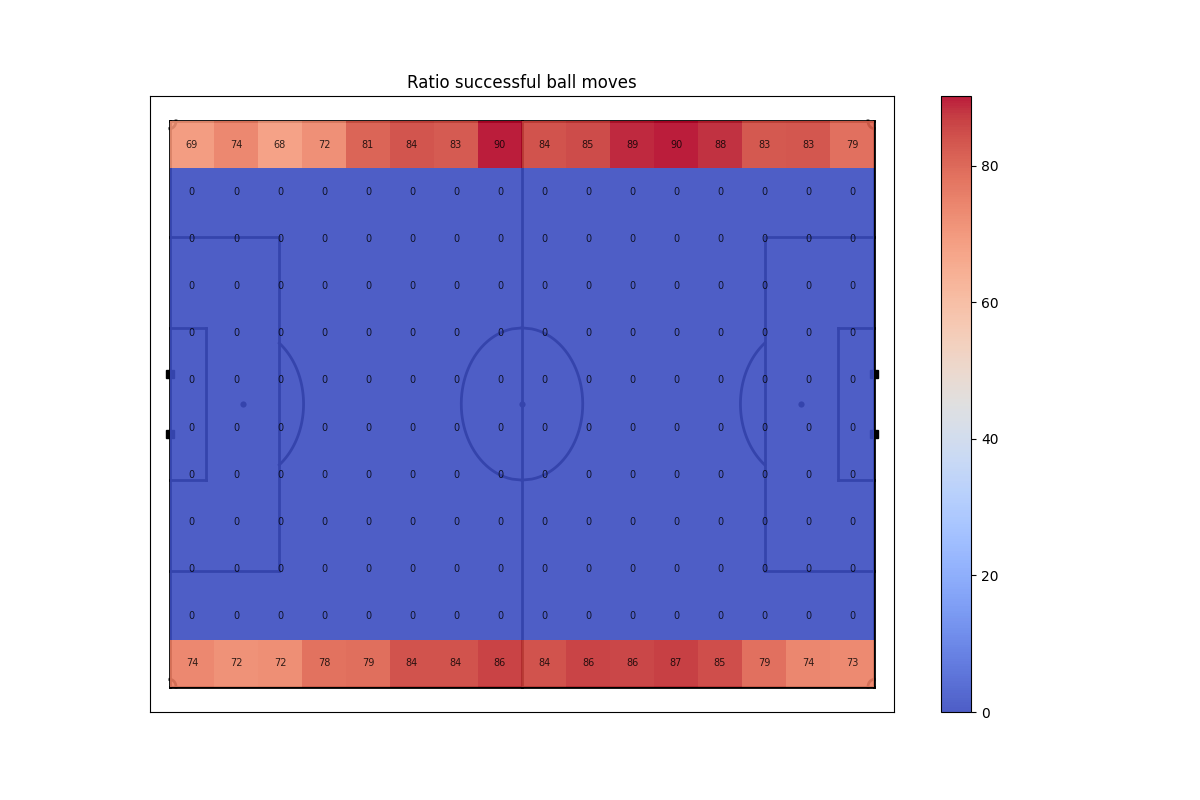

In [350]:
N_X_BINS = 16
N_Y_BINS = 12
X_RANGE = (-53, 53)
Y_RANGE = (-34, 34)
pitch_length = 106
pitch_width = 68
cell_length = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
cell_width = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

params = {"bins": (N_X_BINS, N_Y_BINS), "range": [X_RANGE, Y_RANGE]}

hist_events, x_edges, y_edges = np.histogram2d(throw_ins['start_x'], throw_ins['start_y'], **params)
hist_shots, _, _ = np.histogram2d(throw_ins.loc[throw_ins["event"]=="shot", 'start_x'], throw_ins.loc[throw_ins["event"]=="shot", 'start_y'], **params)
hist_goals, _, _ = np.histogram2d(
    throw_ins.loc[((throw_ins["event"]=="shot") & (throw_ins["successful"]==1)), 'start_x'], 
    throw_ins.loc[((throw_ins["event"]=="shot") & (throw_ins["successful"]==1)), 'start_y'], 
    **params
) 
hist_ball_moves, _, _ = np.histogram2d(throw_ins.loc[throw_ins["event"]!="shot", 'start_x'], throw_ins.loc[throw_ins["event"]!="shot", 'start_y'], **params)
hist_ball_moves_succ, _, _ = np.histogram2d(
    throw_ins.loc[((throw_ins["event"]!="shot") & (throw_ins["successful"]==1)), 'start_x'], 
    throw_ins.loc[((throw_ins["event"]!="shot") & (throw_ins["successful"]==1)), 'start_y'], 
    **params
)
ratio_ball_moves = np.divide(hist_ball_moves, hist_events, where=hist_events!=0)
ratio_ball_moves_succ = np.divide(hist_ball_moves_succ, hist_ball_moves, where=hist_ball_moves!=0)
ratio_failed_actions = 1 - (ratio_ball_moves * ratio_ball_moves_succ) - (ratio_shots * ratio_goals)

plot_results(hist_events.ravel()/100., title="N throw ins", add_text=False, )
plot_results(ratio_ball_moves_succ.ravel(), title="Ratio successful ball moves", add_text=True)

In [351]:
succ_move_probs = np.zeros((N_X_BINS * N_Y_BINS, N_X_BINS * N_Y_BINS))
xg_vals = np.zeros(N_X_BINS * N_Y_BINS)

cell_id = 0
for x_start1, x_start2 in zip(x_edges[:-1], x_edges[1:]):
    # df of all events that are within the x range
    start_df_x = throw_ins[((throw_ins["start_x"] >= x_start1) & (throw_ins["start_x"] <= x_start2))]
    for y_start1, y_start2 in zip(y_edges[:-1], y_edges[1:]):
        # df of all events that are within the x and the y range
        start_df = start_df_x[((start_df_x["start_y"] >= y_start1) & (start_df_x["start_y"] <= y_start2))]
        succ_mask = (~start_df["end_x"].isnull()) & (~start_df["end_y"].isnull()) & (start_df["event"]!="shot") & (start_df["successful"]==1)
        hist_ball_moves_succ_current_pos, _, _ = np.histogram2d(start_df.loc[succ_mask, "end_x"], start_df.loc[succ_mask, "end_y"], **params)
        if len(start_df) > 0:
            current_ratio = hist_ball_moves_succ_current_pos / len(start_df)
        else:
            current_ratio = np.zeros(hist_ball_moves_succ_current_pos.shape)
        succ_move_probs[cell_id] = current_ratio.ravel()
        
        cell_id += 1   

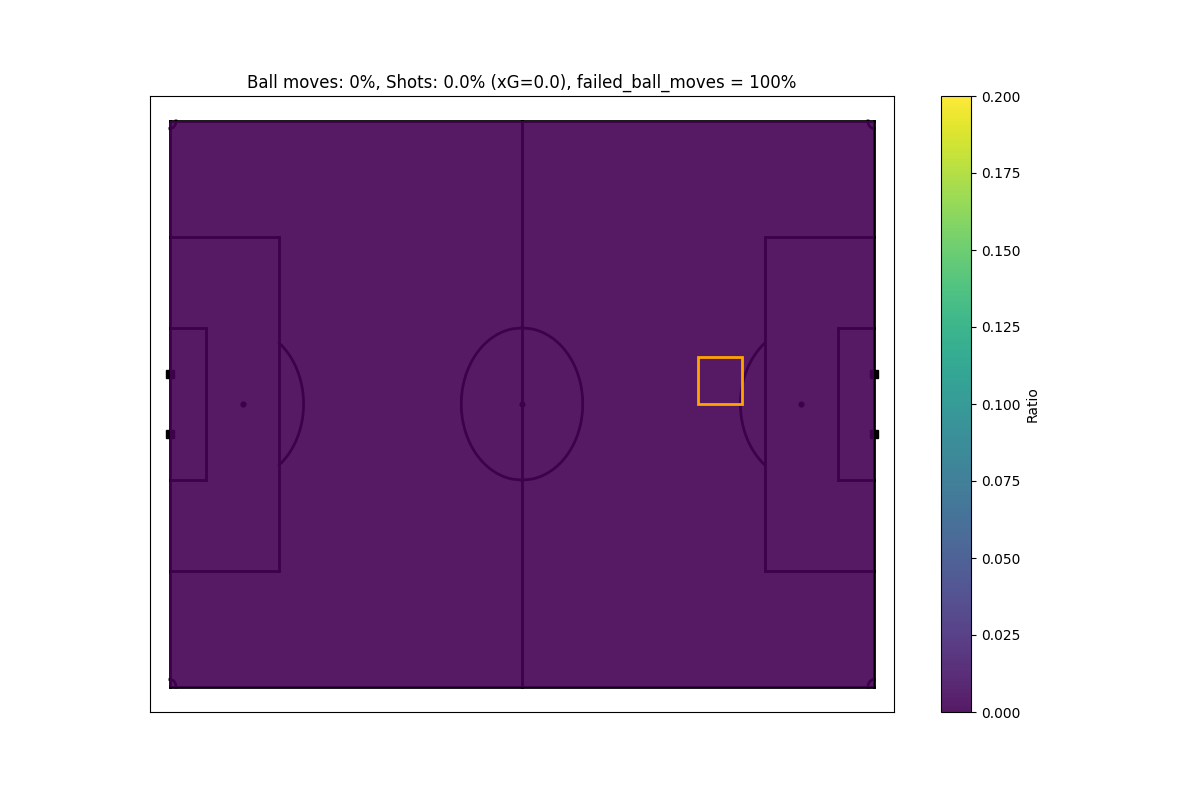

In [352]:
%matplotlib widget

box_width = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
box_height = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

idx = int(N_Y_BINS * (N_X_BINS - int(0.3*N_X_BINS)) + (0.5 * N_Y_BINS))
x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height

plt.close("all")
fig, ax = plot_soccer_pitch(pitch_color="white")
ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.2)
fig.colorbar(pcm, ax=ax, label="Ratio")

ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
ratio_failed_ball_move = (100 - ratio_suc_ball_move_per)

ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: 0.0% (xG={0.0}), failed_ball_moves = {ratio_failed_ball_move}%")
rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
ax.add_patch(rec)
fig.canvas.draw_idle()


pitch_size = (X_RANGE[1] - X_RANGE[0], Y_RANGE[1] - Y_RANGE[0])
add_mirrored_index = False
def on_click(event):
    if event.inaxes == ax:

        [col.remove() for col in ax.collections]
        [patch.remove() for patch in ax.patches]
        [text.remove() for text in ax.texts]
        
        x = event.xdata
        y = event.ydata
        x_idx = np.floor((x + X_RANGE[1]) / (pitch_size[0] / N_X_BINS))
        y_idx = np.floor((y + Y_RANGE[1]) / (pitch_size[1] / N_Y_BINS))
        idx = int(x_idx * N_Y_BINS + y_idx)
        ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
        pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.2)
        
        x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
        y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height
        rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
        ax.add_patch(rec)

        if add_mirrored_index:
            mirrored_index = get_mirrored_index(idx)
            x2 = X_RANGE[0] + (mirrored_index // N_Y_BINS) * box_width
            y2 = Y_RANGE[0] + (mirrored_index % N_Y_BINS) * box_height
            rec = Rectangle((x2, y2), width=box_width, height=box_height, color='red', fc='none', lw=2)
            ax.add_patch(rec)
        
        ax.scatter([x], [y], color="black")
        
        arrow = mpatches.FancyArrowPatch((x , y), goal_loc, mutation_scale = 20)
        arrow.set_alpha(ratio_shots.ravel()[idx])
        arrow.set_color("white")
        ax.add_patch(arrow)
        
        ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
        ratio_failed_ball_move = (100 - ratio_suc_ball_move_per)
        
        ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: {0.0}% (xG={0.0}), failed_ball_moves = {ratio_failed_ball_move}%")
        ax.axes()
            

        fig.canvas.draw_idle()
fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

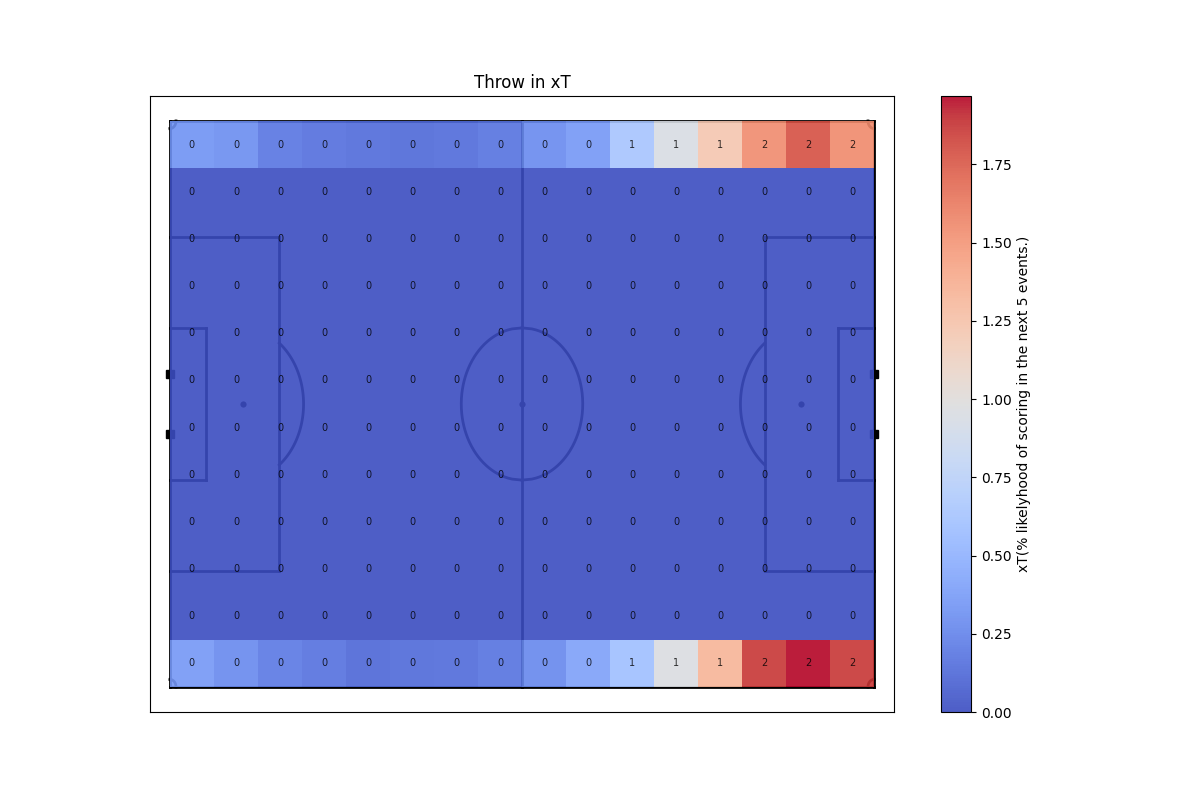

In [353]:
plt.close("all")

throw_in_xT = np.zeros(N_X_BINS * N_Y_BINS)
open_play_xT_grid = np.zeros(N_X_BINS * N_Y_BINS)
for cell in range(len(open_play_xT_grid)):
    x = (cell // N_Y_BINS + 0.5) * cell_length - 53
    y = (cell % N_Y_BINS + 0.5) * cell_width - 34
    open_play_xT_grid[cell] = get_open_play_xt(x, y)

# Loop over all possible location where you can have the ball
for current_cell_id in range(len(throw_in_xT)):

    # throw ins are never shots or goals
    current_cell_xT =  0

    # Loop over all possible ball move options, and their likelyhood of happening successfully
    for to_cell_id in range(len(free_kick_xT)):
        x = (to_cell_id // N_Y_BINS + 0.5) * cell_length - 53
        y = (to_cell_id % N_Y_BINS + 0.5) * cell_width - 34
        

        # Update the xT with the probability of a successful ball move times the xT of that end location in open play
        current_cell_xT += succ_move_probs[current_cell_id, to_cell_id] * open_play_xT_grid[to_cell_id]
    # Save the new xT of the current position
    throw_in_xT[current_cell_id] = current_cell_xT
plot_results(throw_in_xT, title="Throw in xT", label="xT(% likelyhood of scoring in the next 5 events.)" )

Root Mean Square Error of the model is:  0.003


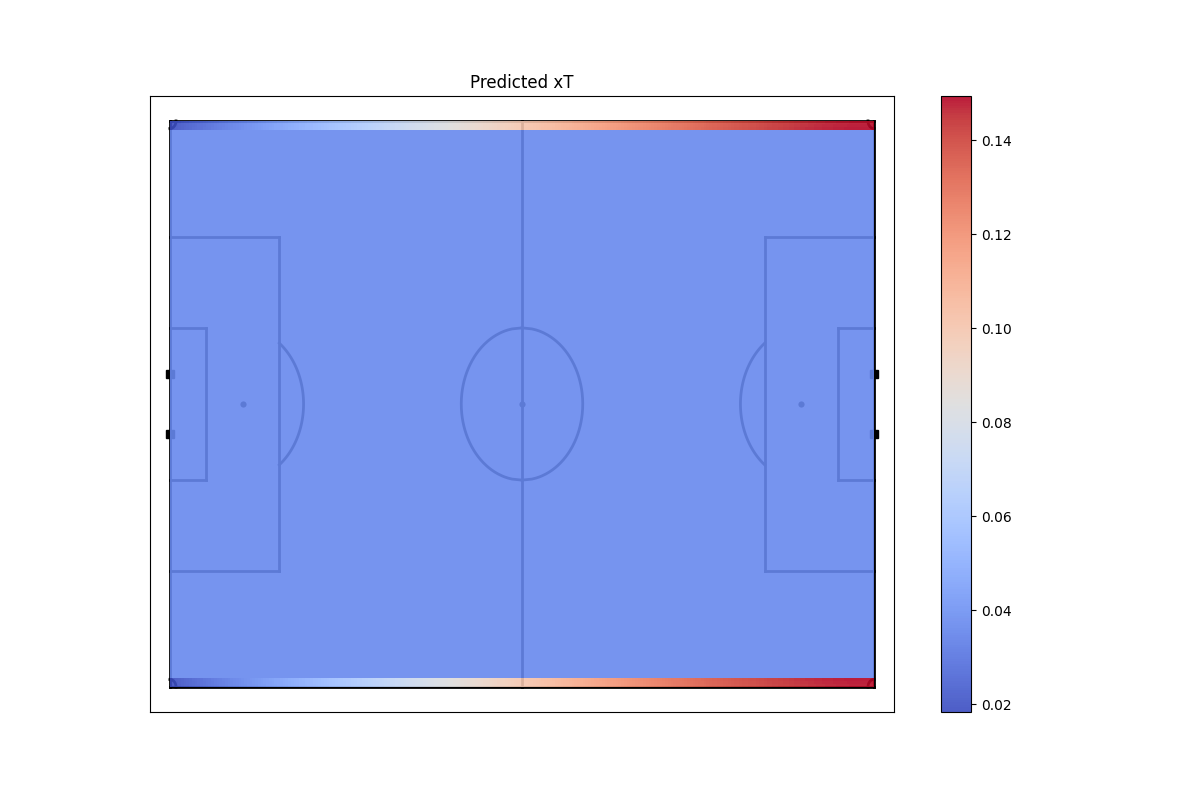

In [363]:
distances = np.zeros(free_kick_xT.shape)

for idx in range(len(throw_in_xT)):
    x = (idx // N_Y_BINS + 0.5) * cell_length - 53
    y = (idx % N_Y_BINS + 0.5) * cell_width - 34

    distances[idx] = math.dist(np.array([x, y]), goal_loc)


norm_dist = distances/distances.max()
X = np.array([norm_dist]).T
y = throw_in_xT.copy()

lr_xt_throw_in = LinearRegression()
lr_xt_throw_in.fit(X, y)
print("Root Mean Square Error of the model is: ", np.sqrt(mean_squared_error(y, lr_xt_throw_in.predict(X))).round(3))

distances_2 = np.zeros(256*196)
angles_2 = np.zeros(256*196)
for idx in range(256*196):
    x = (idx // 196 + 0.5) * (106/256) - 53
    y = (idx % 196 + 0.5) * (68/196) - 34
    if np.abs(y) < 33:
        distances_2[idx] = 100
    else:
        distances_2[idx] = math.dist(np.array([x, y]), goal_loc)

X = np.array([distances_2/distances.max()]).reshape(-1, 1)

output = lr_xt_throw_in.predict(X)
_, x_edges2, y_edges2 = np.histogram2d(df['start_x'], df['start_y'], bins=(256, 196), range=[X_RANGE, Y_RANGE])
plot_results(np.clip(output, a_max=1.0, a_min=0.0), title="Predicted xT", x_edges_func=x_edges2, y_edges_func=y_edges2, n_x_bins_func=256, n_y_bins_func=196, add_text=False)

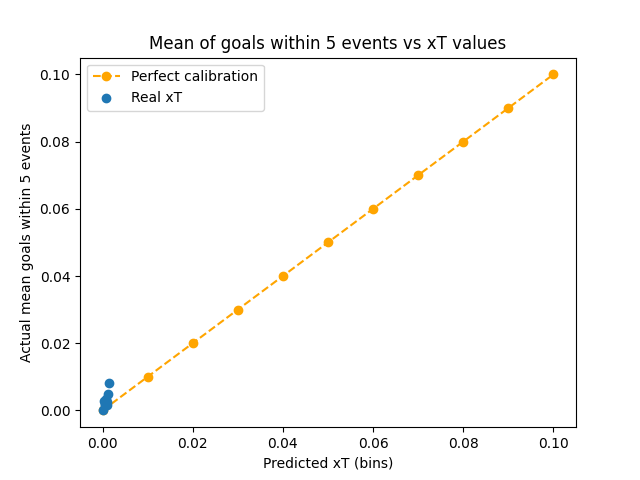

In [367]:
goal_within_5_events = (throw_ins["n_events_next_goal"] < 5).fillna(0)

x, y = throw_ins["start_x"].values, throw_ins["start_y"].values

real_distances = np.linalg.norm(goal_loc - np.array([x, y]).T, axis=1)

X = np.array([real_distances/distances.max()]).reshape(-1, 1)
xt_values = np.clip(lr_xt_throw_in.predict(X), a_min=0.0, a_max=1.0)

bins = np.linspace(xt_values.min(), xt_values.max(), 10)
bin_indices = np.digitize(xt_values, bins)
bin_means = [np.nanmean(np.array(goal_within_5_events)[bin_indices == i]) for i in range(1, len(bins))]
plt.close("all")
fig, ax = plt.subplots()

ax.plot(np.linspace(0, .1, 11), np.linspace(0, .1, 11), marker="o", label="Perfect calibration", linestyle='--', color="orange", zorder=-1)
ax.scatter(bins[:-1], np.array(bin_means), label="Real xT")
ax.set_xlabel('Predicted xT (bins)')
ax.set_ylabel('Actual mean goals within 5 events')
ax.set_title('Mean of goals within 5 events vs xT values')
ax.legend()
plt.show()

In [368]:
import joblib

save_dir = "../databallpy/models"
joblib.dump(lr_xt_throw_in, f"{save_dir}/xt_throw_ins.pkl")
print(f"distance_max: {distances.max()}")

distance_max: 107.31301769757997
